# 평가문항
1. 인물모드 사진을 성공적으로 제작하였다.
    - 아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
    - 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
    - semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.

# 모듈 임포트

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 이미지 불러오기 및 모델 불러오기

#### 이미지 불러오기

(1440, 1080, 3)


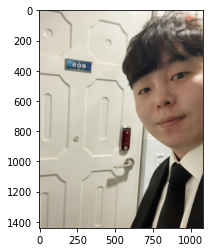

In [3]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/myimage.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### 모델 불러오기 및 생성하기

In [4]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

#세그멘테이션 모델 생성
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

#### 모델에 이미지 삽입

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

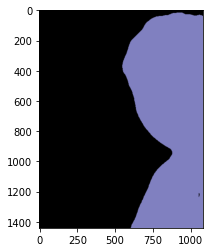

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


- 0번: background(검은색) / 15번: person(남색)을 나타냄

#### 컬러맵 생성하기

In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
print(colormap[0]) #배경
print(colormap[15]) #사람

[0 0 0]
[192 128 128]


- 여기서 주의할 점은 output 이미지가 BGR 순서로 채널 배치가 되어있기때문에 RGB의 순서로 바꿔줘야함 

In [12]:
#색상 순서 변경
seg_color = (128,128,192)

(1440, 1080)


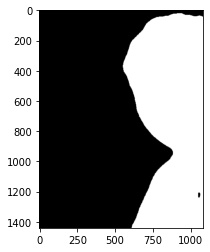

In [13]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

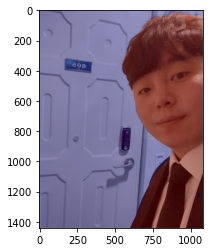

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

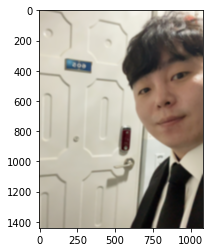

In [16]:
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

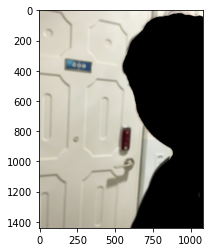

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 합성

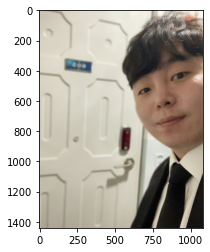

In [18]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 동물사진 적용해보기

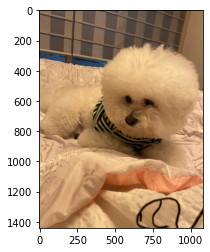

In [19]:
img_path= os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg'
img_orig = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
segvalues, output = model.segmentAsPascalvoc(img_path)

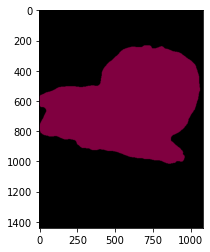

In [21]:
plt.imshow(output)
plt.show()

In [22]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [24]:
print(colormap[0]) # 배경
print(colormap[12]) # 강아지

[0 0 0]
[ 64   0 128]


In [25]:
seg_color_dog = (128,0,64)

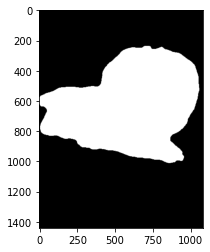

In [26]:
seg_map_dog = np.all(output==seg_color_dog, axis=-1)
plt.imshow(seg_map_dog, cmap='gray')
plt.show()

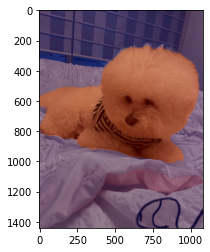

In [27]:
img_show = img_orig.copy()

img_mask = seg_map_dog.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

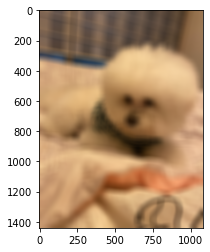

In [30]:
img_orig_blur = cv2.blur(img_orig, (50,50))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

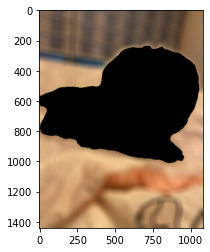

In [31]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

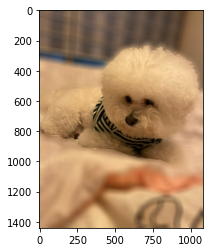

In [32]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 크로마키 적용해보기

(1440, 1080, 3)


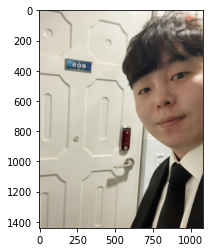

In [48]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/myimage.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

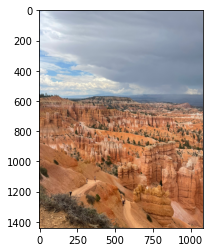

In [53]:
grand_img = os.getenv('HOME')+'/aiffel/human_segmentation/images/grand1.jpg'  
grand_orig = cv2.imread(grand_img)
grand_orig = cv2.resize(grand_orig, (img_orig.shape[1],img_orig.shape[0]))
plt.imshow(cv2.cvtColor(grand_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [54]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [55]:
print(colormap[15]) # 사람

[192 128 128]


In [56]:
seg_color = (128,128,192)

(1440, 1080)


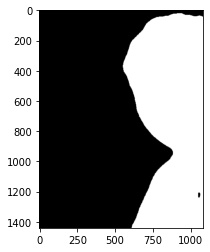

In [57]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

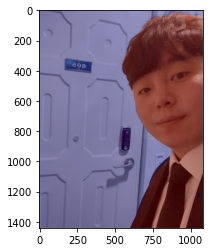

In [58]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

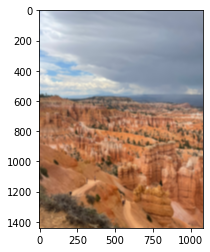

In [59]:
img_orig_blur = cv2.blur(grand_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

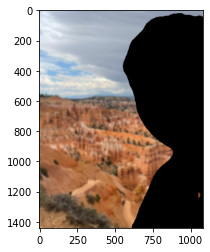

In [60]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

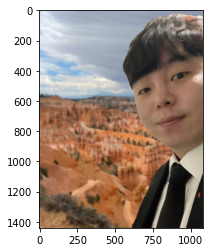

In [61]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점
- 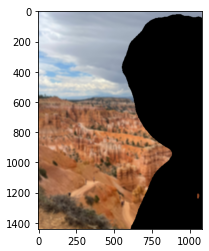
- 이 사진을 봤을때, 사람인 부분에 배경이 적용되어 있는것을 볼 수 있다.
- 저 당시 옷에 아무것도 붙어있는게 없었는데, 저 부분을 배경으로 인식한것 같다.

- 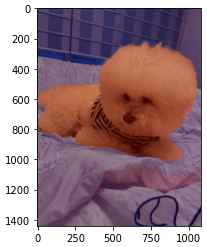
- 해당 사진은 털끝 부분이 배경과 분리하여 제대로 인식하지 못하는것 같다.


- 두 사진 모두 output 부분이 세밀하게 설정되어 있지 않은 것 같다는 생각이 들었다.
- 해당 부분을 수정한다면 좀 더 정교한 분류가 되지 않을까 싶다.

# 전체 회고
- cv는 하면 할수록 재미는 있는것 같다.
- 하지만 코드적으로나 적용하는 부분들이 조금은 많이 생소해서 어렵게 느껴진다.
- 마지막 문제점 찾는 부분도 내가 맞게 설명을 했는지 모르겠다.
- output 부분에서 뭔가 문제가 있어서 분류를 잘 못한거 같기는 한데, 어떤 부분을 어떻게 수정해야할지는 공부를 좀 더 해봐야 알 수 있을것 같다.